# Hi :)

----

# Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Loading the data

In [3]:
# Load data
file_path= "pendulum_noisy_data.xlsx"
df= pd.read_excel(file_path)

# Extract true states and noisy measurements
true_states= df[['x1', 'x2', 'x3', 'x4']].values
measurements= df[['y1', 'y2']].values
num_steps= len(measurements)

# Initialization

In [10]:
# Physical parameters
m= 0.1
M= 5.0
g= 9.81
l= 0.72
dt= 0.001

# Dynamics model
def pendulum_dynamics(x, u):
    x1, x2, x3, x4= x
    dx1= x2

    num2= u * np.cos(x1) - (M + m) * g * np.sin(x1) + m * l * np.cos(x1) * np.sin(x1) * x2**2
    den2= m * l * np.cos(x1)**2 - (M + m) * l
    dx2= num2 / den2 if den2 != 0 else 0

    dx3= x4

    num4= u + m * l * np.sin(x1) * x2**2 - m * g * np.cos(x1) * np.sin(x1)
    den4= M + m - m * np.cos(x1)**2
    dx4= num4 / den4 if den4 != 0 else 0

    return np.array([dx1, dx2, dx3, dx4])

# Observation model: observe x1 and x3
def observation_model(x):
    return np.array([x[0], x[2]])

# Systematic resampling
def systematic_resample(particles, weights):
    N= len(weights)
    positions= (np.arange(N) + np.random.uniform()) / N
    indexes= np.zeros(N, dtype= int)
    cumulative_sum= np.cumsum(weights)
    i, j= 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i]= j
            i += 1
        else:
            j += 1
    return particles[indexes]

# Parameters
num_particles= 100
state_dim= 4
process_noise_std= np.array([0.01, 0.1, 0.01, 0.1])  # per state
measurement_noise_std= 0.05  # assumes same std for x1 and x3

# Initialization around first measurement
initial_mean= [measurements[0, 0], 0, measurements[0, 1], 0]
particles= np.random.normal(loc= initial_mean, scale= 0.2, size= (num_particles, state_dim))
weights= np.ones(num_particles) / num_particles
estimated_states= np.zeros((num_steps, state_dim))

# PF

In [11]:
# Main loop
for t in range(num_steps):
    u= 0  # no control input

    # Predict step
    for i in range(num_particles):
        dx= pendulum_dynamics(particles[i], u)
        process_noise= np.random.normal(0, process_noise_std)
        particles[i] += dx * dt + process_noise

    # Update weights
    z= measurements[t]
    for i in range(num_particles):
        predicted_z= observation_model(particles[i])
        error= z - predicted_z
        weights[i]= np.exp(-0.5 * np.sum((error / measurement_noise_std)**2))

    weights += 1.e-300
    weights /= np.sum(weights)

    # Estimate state
    estimated_states[t]= np.average(particles, weights= weights, axis= 0)

    # Resample if needed
    effective_N= 1. / np.sum(weights**2)
    if effective_N < num_particles / 2:
        particles= systematic_resample(particles, weights)
        weights.fill(1.0 / num_particles)

# RMSE

In [12]:
# Compute RMSE for each state variable
rmse= np.sqrt(np.mean((estimated_states - true_states)**2, axis= 0))

# Display RMSE for each state
for i in range(4):
    print(f"RMSE for x{i + 1}: {rmse[i]:.4f}")

RMSE for x1: 1014.6427
RMSE for x2: 299.6184
RMSE for x3: 1842.4285
RMSE for x4: 411.8096


# Visualization

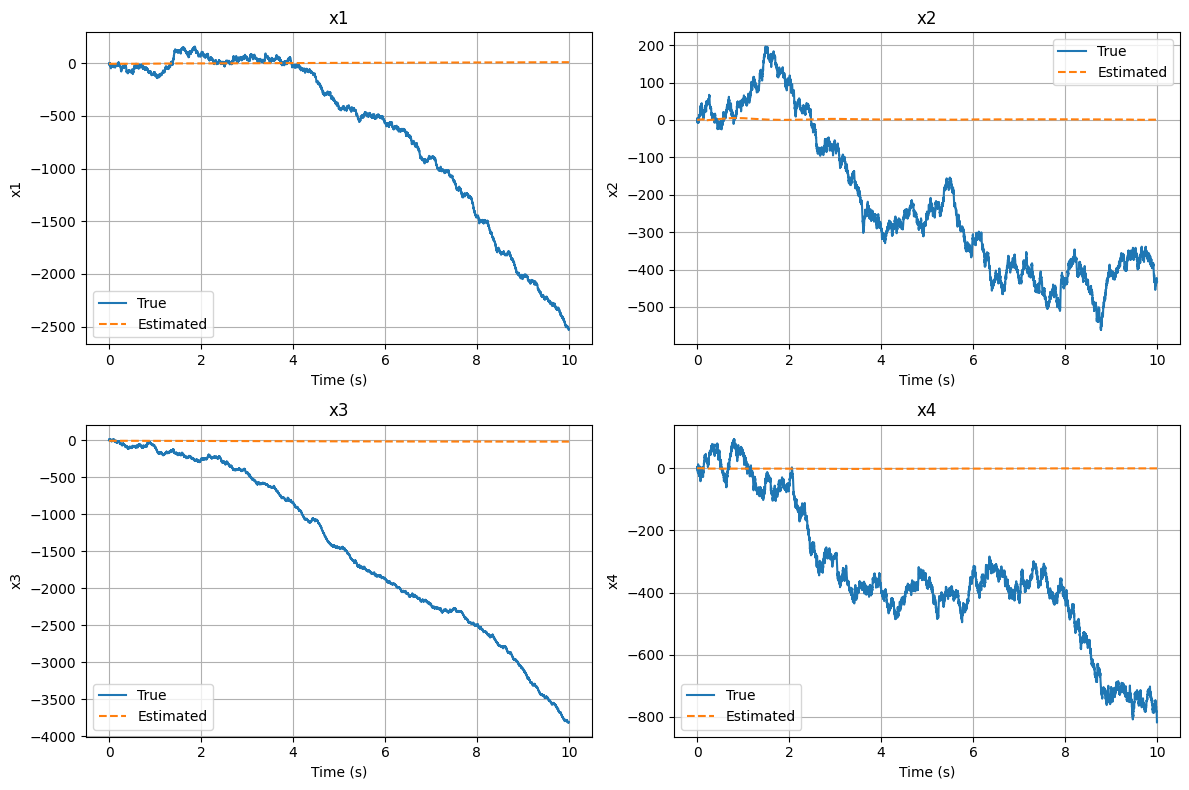

In [13]:
# Plot estimated vs true states
time= np.arange(num_steps) * dt
labels= ['x1', 'x2', 'x3', 'x4']

plt.figure(figsize= (12, 8))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(time, true_states[:, i], label= 'True')
    plt.plot(time, estimated_states[:, i], label= 'Estimated', linestyle= '--')
    plt.title(labels[i])
    plt.xlabel('Time (s)')
    plt.ylabel(labels[i])
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()